# Andrew Kim

# ADS 509-01-SU23: Applied Text Mining

# Assignment 3.1: Group Comparison

# 5/29/2023

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
!pip install wordcloud

In [2]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [3]:
# Use this space for any additional import statements you need
import numpy as np
import glob
import string
from nltk import FreqDist
from PIL import Image
import wikipedia

In [4]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum(len(i) for i in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        c = Counter(tokens)
        top_five = c.most_common(5)
        top_five_df = pd.DataFrame(top_five, columns= ['Token', 'Count'])
        print("\nFive Most Common Tokens: \n\n", top_five_df)

    return(0)


def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(text, sw=sw) :
    # modify this function to remove stopwords
    return([ch for ch in text if ch not in sw])

def remove_punctuation(text, punct_set=tw_punct) : 
   text = [''.join(ch for ch in word if ch not in punct_set)
           for word in text]
   
   return(text)

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    text = text.strip().split()
    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [5]:
# Feel free to use the below cells as an example or read in the data in a way you prefer

# Change to your location if it is not in the same directory as your notebook
data_location = "C:/Users/andre/OneDrive/Documents/ADS509/textrepo/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

In [6]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [7]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [8]:
# read in the lyrics here
# similar input of data from previous assignment
artists = ["eltonjohn", "nirvana"]
lyrics_filepaths = []
artist_list = []

for i in artists:

    # Set file path for each artist before combining the paths to create df
    path = data_location + lyrics_folder + i
    txt_files = glob.glob(os.path.normpath(os.path.join(path, "*.txt")))
    temp_list = [i] * len(txt_files)
    artist_list = artist_list + temp_list
    lyrics_filepaths = lyrics_filepaths + txt_files

lyrics_list = []
song_list = []

for file in lyrics_filepaths:
    # Song titles
    file_temp = open(file, "r")
    title = file_temp.readline().rstrip()
    song_list.append(title)

    # Lyrics
    list = file_temp.readlines()[1:]
    lyrics = "".join(list)
    lyrics = lyrics.replace('\n', " ")
    lyrics_list.append(lyrics)
    file_temp.close()

# Convert to df
dict = {'artist': artist_list, 'song': song_list, 'lyrics': lyrics_list}
lyrics_data = pd.DataFrame(dict)

lyrics_data.head(10)

,artist,song,lyrics
0,eltonjohn,"""All Across The Havens""",The sister of sunlight Comes to my lonely l...
1,eltonjohn,"""Border Song""","Holy Moses, I have been removed I have seen..."
2,eltonjohn,"""Empty Sky""","I'm not a rat to be spat on, locked up in t..."
3,eltonjohn,"""First Episode At Hienton""",I was one as you were one And we were two s...
4,eltonjohn,"""Gulliver""",Gulliver's gone to the final command of his...
5,eltonjohn,"""Hymn 2000""",She chose the soft center And took it to be...
6,eltonjohn,"""I Need You To Turn To""",You're not a ship to carry my life You are ...
7,eltonjohn,"""It's Me That You Need""",Hey there Look in the mirror Are you afraid...
8,eltonjohn,"""Just Like Strange Rain""",I looked up from my glass into the sky Ther...
9,eltonjohn,"""Lady Samantha""",When the shrill winds are screaming And the...


In [9]:
lyrics_data.tail()

,artist,song,lyrics
35,nirvana,"""Scoff""","In my eyes, I'm not lazy In my face, it's n..."
36,nirvana,"""Sifting""","Afraid to grade Wouldn't it be fun? Cross, ..."
37,nirvana,"""Smells Like Teen Spirit""","Load up on guns, bring your friends It's fu..."
38,nirvana,"""Swap Meet""",They live a lifestyle that is comfortable T...
39,nirvana,"""Territorial Pissings""","Come on, people, now Smile on your brother ..."


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [10]:
# Apply the 'pipeline' techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, tokenize, remove_punctuation, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)  

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [11]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [12]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
771248,cher,"IF IT IS TO BE, IT IS UP TO ME! DO WHAT YOU AR...","[able, fight, rule, law, rights, choose, marry..."
112985,robyn,Waiting ✗❤O | Trilogy || Kiss Land ||| Beauty ...,"[waiting, ✗❤o, , trilogy, , kiss, land, , beau..."
371517,cher,Irish ☘️ PA to @hannawaystella | NHS 💙,"[irish, ☘️, pa, hannawaystella, , nhs, 💙]"
1070706,cher,"🐝🐝🐝 Photographer Artist - art, fashion, books ...","[🐝🐝🐝, photographer, artist, , art, fashion, bo..."
1147820,cher,yêu màu hồng và ghét sự giả dối 😂😂😂,"[yêu, màu, hồng, và, ghét, sự, giả, dối, 😂😂😂]"
3957361,cher,save the animals 🐾 love is love 🌈 be kind ♥️ b...,"[save, animals, 🐾, love, love, 🌈, kind, ♥️, be..."
351614,robyn,🎬 Producer 🍁 Cannabis (https://t.co/hrr9molJce...,"[🎬, producer, 🍁, cannabis, httpstcohrr9moljce🧴..."
650380,cher,"Obstinate, headstrong girl 📖","[obstinate, headstrong, girl, 📖]"
272238,robyn,Förskollärare. Träning. Vänner. Vin. Ishockey....,"[förskollärare, träning, vänner, vin, ishockey..."
581912,cher,Live laugh love 💖,"[live, laugh, love, 💖]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: __One area of improvement to the tokenization process that I could theoretically implement would involve assessing slashes that are separating a combination of words with potentially different meanings. This issue could be resolved by removing stop words to focus on words that are important. In addition, the python package pyspellchecker would be resourceful to fix the grammatical or spell errors within the tokens and the description categories.__

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [13]:
# Calculate descriptive statistics of the lyrics sets of Elton John and Nirvana
eltonjohn = lyrics_data[lyrics_data['artist'] == 'eltonjohn']
eltonjohn_dstats = [element for list_ in eltonjohn['tokens'].values for element in list_]

nirvana = lyrics_data[lyrics_data['artist'] == 'nirvana']
nirvana_dstats = [element for list_ in nirvana['tokens'].values for element in list_]

In [14]:
print("\nElton John Results:\n")
print(descriptive_stats(eltonjohn_dstats))

print("\nNirvana Results:\n")
print(descriptive_stats(nirvana_dstats))


Elton John Results:

There are 2350 tokens in the data.
There are 825 unique tokens in the data.
There are 11311 characters in the data.
The lexical diversity is 0.351 in the data.

Five Most Common Tokens: 

   Token  Count
0    na    121
1  take     31
2  rain     23
3  like     22
4   one     22
0

Nirvana Results:

There are 2157 tokens in the data.
There are 482 unique tokens in the data.
There are 10362 characters in the data.
The lexical diversity is 0.223 in the data.

Five Most Common Tokens: 

   Token  Count
0  dont     85
1    im     79
2  girl     52
3  yeah     48
4  said     38
0


Q: what observations do you make about these data? 

A: __The results generated greater stats under the categories "tokens", "unique tokens", "characters", and "lexical diversity" for Elton John compared to Nirvana. Within the results, there were 193 more tokens, 343 more unique tokens, 949 characters, and a higher lexical diversity value of 0.351, all for Elton John compared to Nirvana's 0.223 lexical diversity score.__

__The one unique thing that strikes me is that the most common token from Elton John's lyrics is "na", a term he repeated frequently as a post-chorus for his song "Take Me to the Pilot". Having the term "na" appear as the most common token would make some sense to describe Elton John's blend of pop and rock music styles, which he would display energetically when repeating certain tokens.__

__For Nirvana, the most common token was "dont", which he constantly repeated in his song "Breed" when stating "I don't care". The one note I have for Nirvana is that the group loves to repeat certain phrases within some of their songs, which would explain the tokens that are high on the list. For example, the token "im" that generated the second-highest count at 79 is due to the group repeating the phrase "I'm ashamed" in the song "Floyd the Barber".__

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [15]:
# Set request tokens to 5 for corpus cutoff for Robyn-Cher and maximum words to 10 
# for top 10 tokens/ratio of appearances in given corpora
def compare_conc(corpus_1, corpus_2, req_tokens = 5, num_words = 10):
    # Set a data frame for first corpus
    tokens1 = Counter(corpus_1)
    tokens1 = pd.DataFrame.from_dict(tokens1, orient='index').reset_index()
    tokens1 = tokens1.rename(columns={'index' : 'token', 0:'count'})
    tokens1 = tokens1[tokens1['count'] >= req_tokens]

    # Calculate concentration for first corpus
    corlength1 = len(corpus_1)
    tokens1['Conc_one'] = tokens1['count']/corlength1
    
    
    # Set a data frame to identify unique words from second corpus
    tokens2 = Counter(corpus_2)
    tokens2 = pd.DataFrame.from_dict(tokens2, orient='index').reset_index()
    tokens2 = tokens2.rename(columns={'index' : 'token', 0:'count'})
    tokens2 = tokens2[tokens2['count'] >= req_tokens]

    # Calculate concentration for second corpus
    corlength2 = len(corpus_2)
    tokens2['Conc_two'] = tokens2['count']/corlength2
    
    # Now, merge and clean tokens
    token_merge = pd.merge(tokens1, tokens2, how="outer", on=['token', 'token'])
    token_merge = token_merge.dropna()

    # Calculate by concentrations
    token_merge['one_vs_two'] = token_merge['Conc_one']/token_merge['Conc_two']
    token_merge['two_vs_one'] = token_merge['Conc_two']/token_merge['Conc_one']

    # Generate comparitive results
    onevstwo_res = token_merge[['token', 'one_vs_two']].sort_values(by='one_vs_two', 
                                                                    ascending= False).head(10).reset_index()
    twovsone_res = token_merge[['token', 'two_vs_one']].sort_values(by='two_vs_one', 
                                                                    ascending= False).head(10).reset_index()

    print("Corpus One vs. Two:\n", onevstwo_res, "\n\nCorpus Two vs. One:\n", twovsone_res)

In [16]:
# Corpus One : Elton John vs. Corpus Two: Nirvana
compare_conc(eltonjohn_dstats, nirvana_dstats)

Corpus One vs. Two:
    index   token  one_vs_two
0     46     one    2.243688
1     13    take    1.778378
2     60    come    1.721011
3     58   youre    1.668859
4     16      us    1.529787
5     30    high    1.491543
6     52     see    1.180122
7     81  living    1.101447
8     44    like    1.062800
9     47    eyes    1.059083 

Corpus Two vs. One:
    index token  two_vs_one
0     54  said    8.280019
1     23  dont    5.447381
2     12    im    4.781590
3     19   way    4.494089
4      9  aint    4.357904
5     18  find    3.579707
6    130  mind    3.450008
7    113   gun    3.268428
8     42  yeah    3.076168
9     78  know    2.801510


In [17]:
# Set twitter corpora for tokens and to compare results
cher = twitter_data[twitter_data['artist'] == 'cher']
cher_ctokens = [element for list_ in cher['tokens'].values for element in list_]

rob = twitter_data[twitter_data['artist'] == 'robyn']
rob_ctokens = [element for list_ in rob['tokens'].values for element in list_]

In [18]:
# Corpus One : Cher vs. Corpus Two : Robyn
compare_conc(cher_ctokens, rob_ctokens, req_tokens=5)

Corpus One vs. Two:
    index           token  one_vs_two
0    357     grandmother   35.616133
1   1012            #fbr   24.756591
2    773        resister   24.628951
3    901       #resister   24.214176
4    835            nana   23.839388
5  28554          rbsoul   20.738742
6    300         grandma   20.048455
7     29  #theresistance   19.041859
8  24422       hiphoprap   18.093484
9   2514             gop   17.458497 

Corpus Two vs. One:
     index     token  two_vs_one
0   92014    vänner  290.884148
1  101594      bäst  208.677758
2   77096  sveriges  206.569902
3   48124   träning  202.002881
4   82475   brinner  197.235111
5   15354      följ  194.098420
6   55975     gärna  193.539519
7   91350   arbetar  185.874587
8   83236     varje  182.680866
9   22591    familj  179.167772


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: __For the lyrics comparison list, it is difficult to dissect any items or tokens that stand out over others since about every word within the lists could be labeled as general stop words. Based off the list, the token words from "Corpus One vs. Two" coincide with Elton John's musical style. Terms such as "high" and "living" indicate John's accomplishments in standardizing and revolutionizing a blend of different musical styles while bringing a positive, energetic vibe across society. The token words from "Corpus Two vs. One", especially terms like "dont", "aint", and "gun", best coincide the group's style in being a punk rock group with a rebellious, teen, overly loud, and troublesome vibe within their music.__

__For the twitter comparison list, the token items between the artists Cher and Robyn offer unique insights regarding their fanbase. The tokens from Cher's list ("Corpus One vs. Two") indicates her fanbase is being primarily dominated by the elderly group. On the contrary, the tokens from Robyn's list ("Corpus Two vs. One") indicates her fanbase is solely dominated by Swedens. This in turn generates a unique perspective of the cultural comparison of artists' fanbase across different nations.__

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [19]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

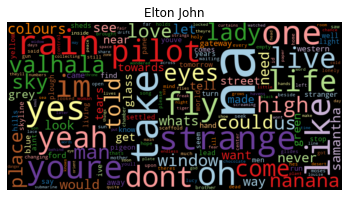

In [20]:
# Word cloud for lyrics corpus: Elton John
eltonjohn_wcloud = count_words(eltonjohn)
wordcloud(eltonjohn_wcloud['freq'], title="Elton John")

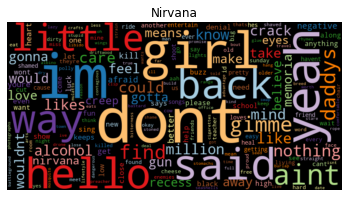

In [21]:
# Word cloud for lyrics corpus: Nirvana
nirvana_wcloud = count_words(nirvana)
wordcloud(nirvana_wcloud['freq'], title="Nirvana")

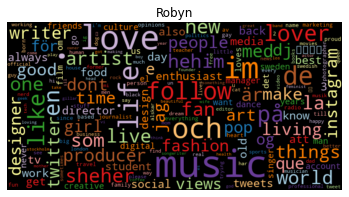

In [22]:
# Word cloud for twitter corpus: Robyn
rob_count = count_words(rob)
rob_count = rob_count.drop(index = ('nan'))
wordcloud(rob_count['freq'], title = "Robyn")

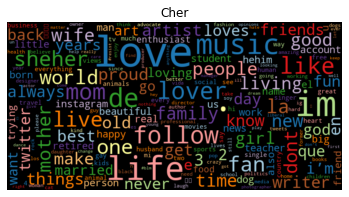

In [23]:
# Word cloud for twitter corpus: Cher
cher_count = count_words(cher)
cher_count = cher_count.drop(index = ('nan'))
wordcloud(cher_count['freq'], title = "Cher")

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: __To my surprise, the word cloud between the lyrics and twitter corpora did not coincide to generate a common theme or shared term. In other words, there is not even a single term that stands out equally between the four corpuses (two lyrics and two twitter).__ 

__For the lyrics corpuses, there were two terms that stand out in being common to one another: "yeah" and "dont". These terms generate a shared theme within the lyrics of Elton John and Nirvana, with both generating a rock and roll vibe within their musical styles to keep their audience or fanbase energetic and hyped up towards a positive or negative aspect.__

__For the twitter corpuses, one term that stands out in being common to one another is "love". Additional terms I note that stand out and is common between both Cher and Robyn are "life", "music", "follow", and "like", which all indicate their musical styles expressing positive vibes across society.__